In [30]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
%load_ext autoreload
%autoreload 2

import skimage.io
import skimage.transform
from skimage import color
import copy
from skimage.segmentation import quickshift, mark_boundaries, slic, felzenszwalb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in C:\Users\Thanh/.cache\torch\hub\pytorch_vision_v0.10.0


In [32]:
if torch.cuda.is_available():
    print("GPU is available")
    model.to('cuda')

GPU is available


In [33]:
import requests
# Download the imagenet_classes.txt file
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)

# Read the categories
class_names = [s.strip() for s in response.text.split('\n')]
class_names[:5]


['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']

In [34]:
def transform_img_fast(path):
    """Purpose: Crop and resize the image to 299x299 for InceptionV3"""
    img = skimage.io.imread(path)
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    if img.shape[2] == 4:
        img = color.rgba2rgb(img)
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy: yy + short_egde, xx: xx + short_egde]
    return (skimage.transform.resize(crop_img, (299, 299)) - 0.5) * 2

def transform_img_fn_fast(paths):
    """Purpose: Transform a list of image paths to a numpy array of images"""
    out = []
    for i, path in enumerate(paths):
        if i % 100 == 0:
            print(i)
        out.append(transform_img_fast(path))
    return np.array(out)
#     return np.array([transform_img_fast(path) for path in paths])

In [35]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [36]:
# def load_images(paths):
#     out = []
#     for path in paths:
#         input_image = Image.open(path)
#         tensor = preprocess(input_image).numpy()
#         out.append(tensor)
#     return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


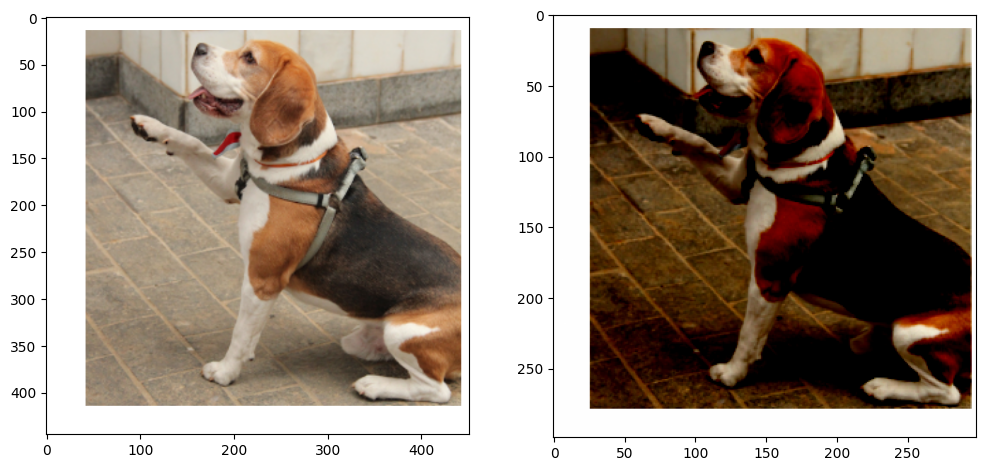

In [37]:
#images = transform_img_fn_fast(['dog.jpg'])
original_image = skimage.io.imread('nick.png')
images = transform_img_fn_fast(['nick.png'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image)
axes[1].imshow(images[0])

plt.show()


In [38]:
def predict(images):
    """Purpose: Predict the class of the image using the InceptionV3 model"""
    images = images.transpose((0, 3, 1, 2)) # Shape in Pytorch: NxCxHxW (N: Number of images, C: Number of channels, H: Height, W: Width)
    input_tensor = torch.FloatTensor(images)
    if torch.cuda.is_available():
        input_tensor = input_tensor.to('cuda')
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy()

In [39]:
def ShowImageNoAxis(image, boundaries=None, save=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if boundaries is not None:
        ax.imshow(mark_boundaries(image / 2 + 0.5, boundaries))
    else:
        ax.imshow(image / 2 + .5)
    if save is not None:
        plt.savefig(save)
    plt.show()


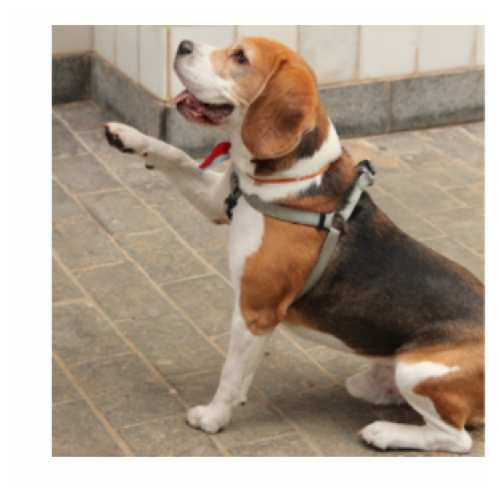

In [40]:
ShowImageNoAxis(images[0])

In [41]:
probs = predict(images)
idxs = np.argsort(-probs[0])
list(zip(probs[0][idxs[:5]], np.array(class_names)[idxs[:5]]))

[(0.94672316, 'beagle'),
 (0.023323683, 'Walker hound'),
 (0.0150852045, 'English foxhound'),
 (0.0005313019, 'basenji'),
 (0.00043689326, 'basset')]

In [42]:
import anchor
import anchor.anchor_image

In [43]:
import anchor
#/home/marcotcr/datasets/openimages/train contains a lot of arbitrary images - in this case, from openimages
explainer = anchor.anchor_image.AnchorImage('../dataset',
                               transform_img_fn=transform_img_fn_fast, n=20)


0


In [44]:
segments, exp = explainer.explain_instance(images[0], predict, threshold=0.95, batch_size=50,
                                            tau=0.20, verbose=True, min_shared_samples=200, beam_size=2)

True pred 162
Best: 27 (mean:0.0000000000, n: 1, lb:0.0000) Worst: 0 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 27 (mean:0.0000000000, n: 51, lb:0.0000) Worst: 54 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 27 (mean:0.0000000000, n: 101, lb:0.0000) Worst: 53 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 27 (mean:0.0066225166, n: 151, lb:0.0000) Worst: 55 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 53 (mean:0.0196078431, n: 51, lb:0.0000) Worst: 52 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 52 (mean:0.0196078431, n: 51, lb:0.0000) Worst: 51 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 55 (mean:0.0196078431, n: 51, lb:0.0000) Worst: 50 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 55 (mean:0.0099009901, n: 101, lb:0.0000) Worst: 49 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 27 (mean:0.0099502488, n: 201, lb:0.0000) Worst: 48 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 55 (mean:0.0132450331, n: 151, lb:0.0000) Worst: 47 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 48 (mea

In [45]:
exp

[(17, '', 0.08636688079942897, [], 0),
 (9, '', 0.2842809364548495, [], 0),
 (4, '', 0.6456310679611651, [], 0),
 (2, '', 0.8791666666666667, [], 0),
 (19, '', 0.9547738693467337, [], 0)]

Anchor for prediction  beagle confidence 0.9547738693467337


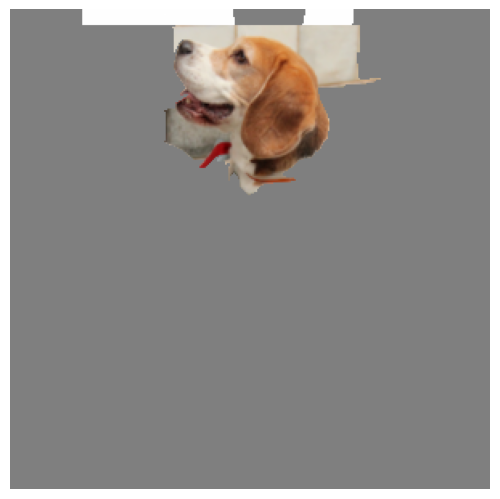

Counter Examples:


In [46]:
def show_exp(segments, exp, image, explainer):
    mask = np.ones(segments.shape).astype(bool)
    temp = copy.deepcopy(image)
    temp_img = copy.deepcopy(temp)
#     temp.img = temp.fudged_image.copy()
    temp[:] = 0
    # for x in exp_greedy[:3]:
    #     x = (x, x)
    for x in exp:
        temp[segments == x[0]] = temp_img[segments==x[0]]
    # temp.img[mask] = np.random.random(mask.nonzero()[0].shape[0] * 3).reshape(mask.nonzero()[0].shape[0], 3)
    print ('Anchor for prediction ', class_names[predict(np.expand_dims(image, 0))[0].argmax()], 'confidence', exp[-1][2])
    ShowImageNoAxis(temp)
    print('Counter Examples:')
    for e in exp[-1][3]:
        data = e[:-1]
        temp = explainer.dummys[e[-1]].copy()
        for x in data.nonzero()[0]:
            temp[segments == x] = image[segments == x]
        ShowImageNoAxis(temp)
        print('Prediction = ', names[predict_fn(np.expand_dims(temp, 0))[0].argmax()])
show_exp(segments, exp, images[0], explainer)

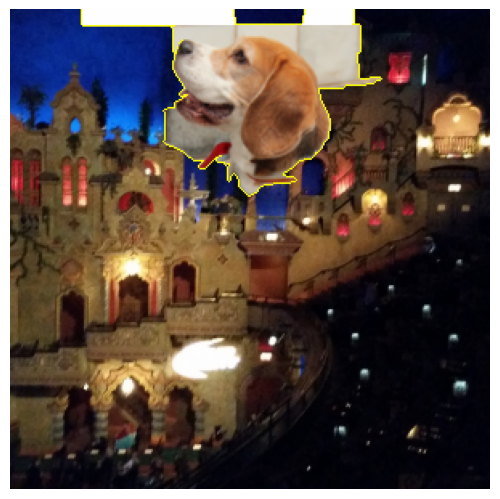

beagle 0.68539035


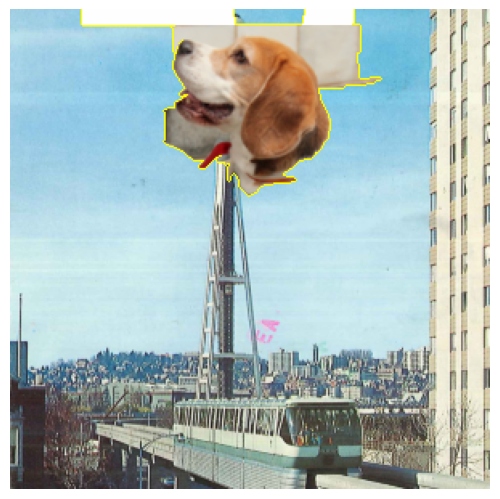

beagle 0.40598932


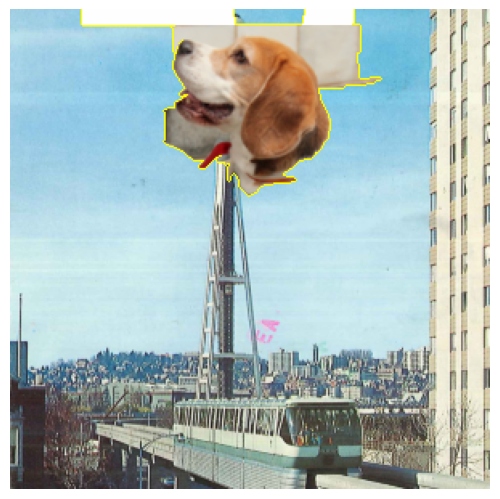

beagle 0.40598932


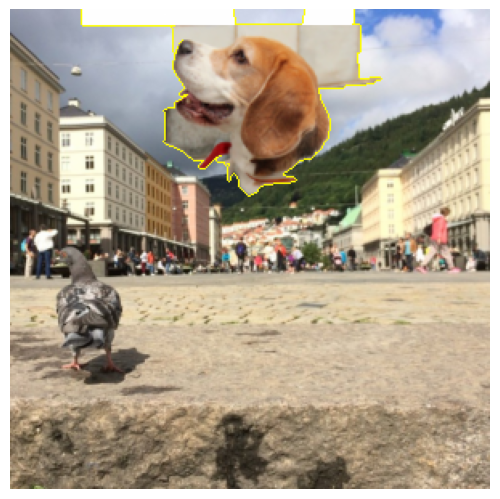

beagle 0.7951632


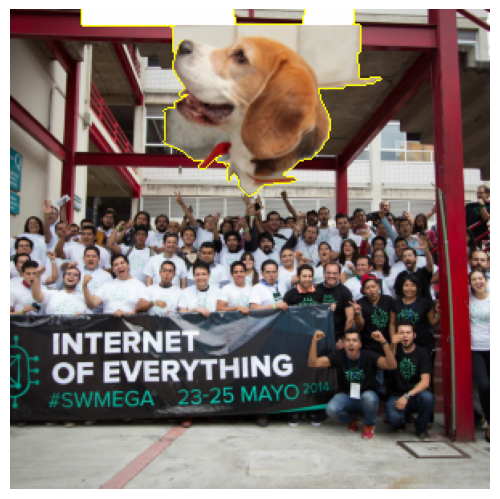

beagle 0.6625128


In [49]:
N = 5
chosen = np.random.choice(len(explainer.dummys), N)
imgs = []
masks = []
for c in chosen:
    temp = copy.deepcopy(explainer.dummys[c])
    mask = np.zeros(segments.shape).astype(bool)
    for f in exp:
        f = f[0]
        mask[segments == f] = 1
    temp[mask] = images[0][mask].copy()
    imgs.append(temp)
    masks.append(mask)
preds = predict(np.array(imgs))
for i, p in zip(imgs, preds):
#     if p.max() < 0.9:
#         continue
    ShowImageNoAxis(i, mask, '../tmp/nickz.png')
    print(class_names[p.argmax()], p.max())